# Preprocessing

**This is a companion code for the publication *Mälicke et al. (2019) Soil moisture: variable in space but redundant in time* (DOI: 10.5194/hess-2019-574). Please refer to the full text for details on the method.**

A number of soil moisture time series will be loaded recorded in the Attert Experimental Watershed. The time series are analysed for spatial dependencies at different points in time. 

**If you use parts of the code, please cite the publication.**
Load packages

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
from datetime import datetime as dt
from scipy.spatial.distance import pdist

The `main.py` in the same folder is a collection of the actual method and some helpful plotting routines.

In [2]:
from main import minmax, extract, dispersion, cluster_variograms, variograms, clustered_series, compress_cluster
from main import plot_variogram, plot_overview, plot_cluster, heat_diagram, plot_compressed
from main import variogram_entropy, entropy_report, cluster_entropy, information_loss

In [3]:
# saving options
main_name = 'results/%s_dispersion_30days_%d.png'

#parameters
rank=False
estimator='cressie'
#maxlag='median'
maxlag=1200
window=30
bandwidth=30
#bandwidth=25
cl_threshold=10

Make the plots for publication friendly

In [4]:
# some rc params
matplotlib.rc('font', **{'size': 20, 'family': 'Ubuntu', 'weight': 'normal'})
matplotlib.rc('axes', **{'labelsize': 20, 'spines.top': False, 'spines.right': False, 'facecolor': 'white'})

## Load data

The data is stored in a HDF5 file. The identifiers for the soil moisture observations are `m10`, `m30` and `m50`. Precipitation data is called `rain` and the air temperature is identified by the `temperature` key.
All data is of daily resolution. The file is available upon request until a data publication is finished.

In [5]:
store = pd.HDFStore('daily_agg.hd5')
store

<class 'pandas.io.pytables.HDFStore'>
File path: daily_agg.hd5

In [6]:
# soil moisture
m10 = store.get('m10')
m30 = store.get('m30')
m50 = store.get('m50')

# rainfall
rain = store.get('rainfall')
temperature = store.get('temperature')
store.close()

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


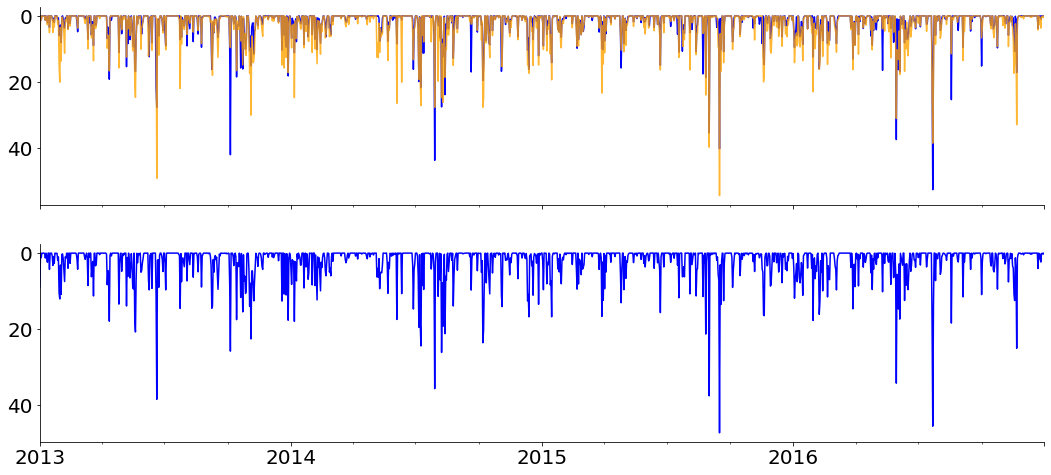

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(18,8), sharex=True)

rr = rain.mean(axis=1)

rain.Useldange.plot(ax=axes[0], color='b')
rain.Roodt.plot(ax=axes[0], color='orange', alpha=0.8)
rr.plot(ax=axes[1], legend=None, color='b')
axes[0].invert_yaxis()
axes[1].invert_yaxis()

## Soil moisture overview

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


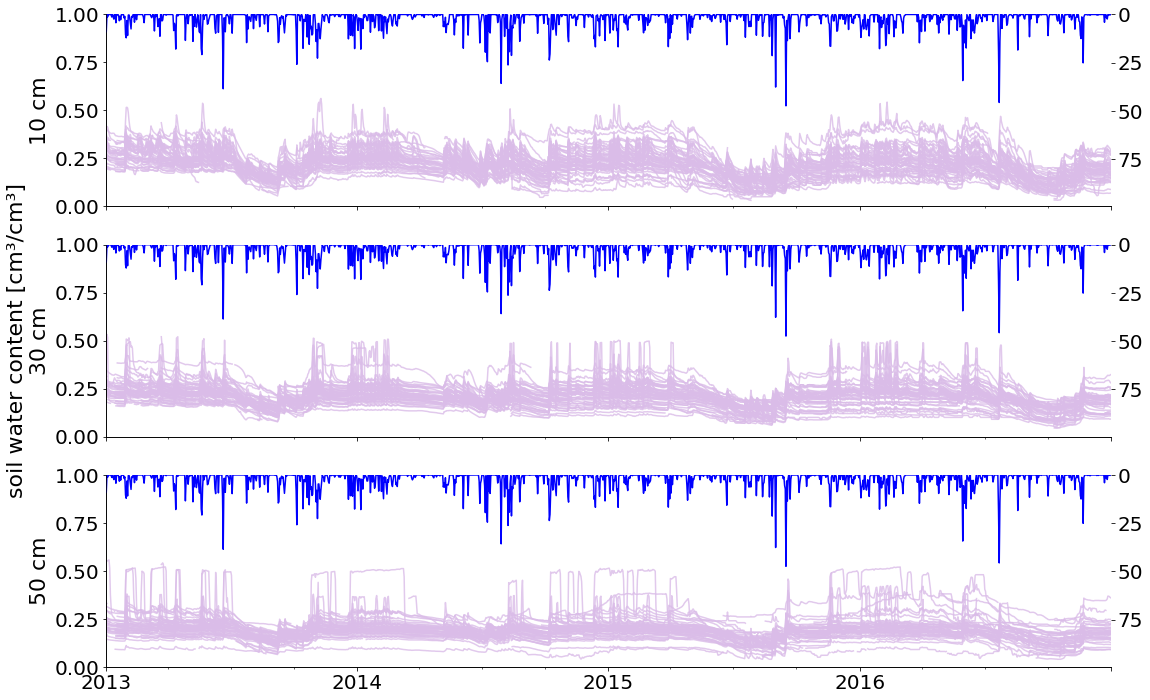

In [8]:
fig, _a = plt.subplots(3,1, figsize=(18, 12), sharex=True, sharey=True)
axes = _a.flatten()

m10.drop(m10.columns[np.where(m10.mean() >= 0.35)].values, axis=1, inplace=True)
m30.drop(m30.columns[np.where(m30.mean() >= 0.35)].values, axis=1, inplace=True)
m50.drop(m50.columns[np.where(m50.mean() >= 0.35)].values, axis=1, inplace=True)

m10.plot(ax=axes[0], color='#DABCE8', legend=None, alpha=0.8)
m30.plot(ax=axes[1], color='#DABCE8', legend=None, alpha=0.8)
m50.plot(ax=axes[2], color='#DABCE8', legend=None, alpha=0.8)

for ax in axes:
    lim = ax.get_ylim()
    ax.set_ylim((0, 1))

ax2 = [ax.twinx() for ax in axes]
for ax in ax2:
    rr.plot(ax=ax, legend=None, color='b')
    ax.invert_yaxis()
    lim = ax.get_ylim()
    ax.set_ylim((lim[0] * 2, 0))

axes[0].set_ylabel('10 cm', fontsize=22)
axes[1].set_ylabel('soil water content [cm³/cm³]\n30 cm', fontsize=22)
axes[2].set_ylabel('50 cm', fontsize=22)

fig.savefig('results/all_data.pdf')

## Spatial information

The spatial information is stored in the `positions.csv` file. Extract the x and y coordinate. The *d* column is a unique identifier, that can be found in the data series as column descriptors. This way, the locations can be mapped to the right data column. The coordinate system is a projected one (EPSG: 2169), using meter as an unit. Therefore no transformation needed.

In [9]:
# get the positions
positions = pd.read_csv('positions.csv')
positions.head()

d             x             y                       start  \
0  32  53693.837759  98752.205367  2012-03-01 18:50:00.000000   
1  33  53693.837759  98752.205367  2012-03-01 18:50:00.000000   
2  34  53693.837759  98752.205367  2012-03-01 18:50:00.000000   
3  35  53691.342952  98749.025185  2012-03-01 18:50:00.000000   
4  90  53665.550000  98779.541089  2012-05-12 18:05:00.000000   

                         stop  elevation  depth  
0  2017-02-07 00:00:00.000000        470     10  
1  2017-02-07 00:00:00.000000        470     30  
2  2012-08-17 11:40:00.000000        470     50  
3  2017-02-07 00:00:00.000000        470     10  
4  2017-02-07 00:00:00.000000        473     10

In [10]:
positions['pos'] = ['pos_%d' % i for i in positions.d.values]
positions['geom'] = [(r['x'], r['y'],) for i,r in positions.iterrows()]

pos10 = positions.where(positions.depth==10).dropna()[['pos', 'x', 'y']]
pos10.set_index('pos', inplace=True)
pos30 = positions.where(positions.depth==30).dropna()[['pos', 'x', 'y']]
pos30.set_index('pos', inplace=True)
pos50 = positions.where(positions.depth==50).dropna()[['pos', 'x', 'y']]
pos50.set_index('pos', inplace=True)

Make an overview plot:

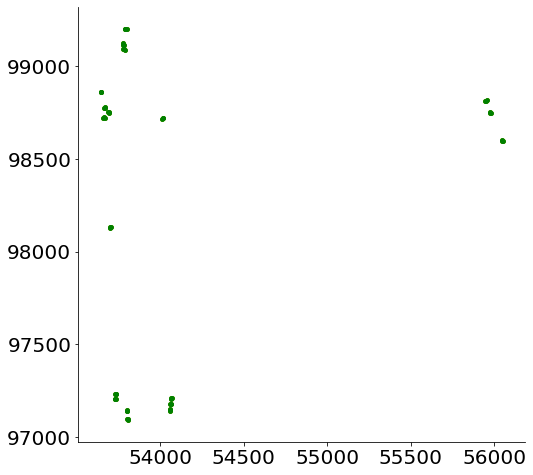

In [11]:
# uncomment these lines to further subset the data
#npos10 = pos10.where((pos10.x < 54500) & (pos10.y < 97500)).dropna()
#npos30 = pos30.where((pos30.x < 54500) & (pos30.y < 97500)).dropna()
#npos50 = pos50.where((pos50.x < 54500) & (pos50.y < 97500)).dropna()
npos10 = pos10
npos30 = pos30
npos50 = pos50

# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(pos10.x.values, pos10.y.values, 15, c='y')
ax.scatter(npos10.x.values, npos10.y.values, 15, c='g')

# Analysis

The following section runs the same code for all years and depths to produce result output graphs.

# 2013

Analysis:

In [12]:
# get data
m2013 = list(extract((m10,m30,m50), '20130101', '20131231'))

# apply analysis
v2013 = variograms(m2013, (npos10, npos30, npos50), binify='uniform',window=window, estimator=estimator, rank=rank, maxlag=maxlag)
mean_shifts2013 = cluster_variograms(v2013, bandwidth=bandwidth)
compress2013 = [compress_cluster(ms, v) for ms, v in zip(mean_shifts2013, v2013)]

## 10 cm

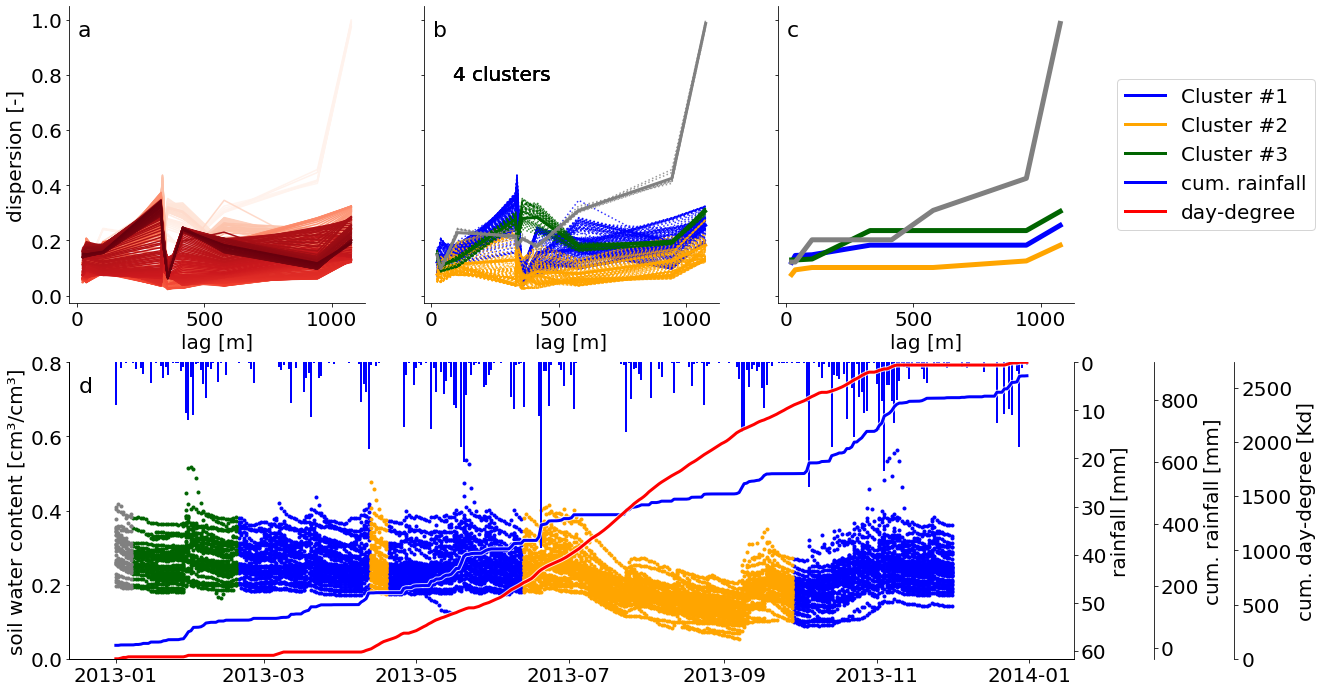

In [13]:
d = 0 # depth:= 10cm

# create figure
fig, axes = plt.subplots(2, 3, figsize=(3*6, 2*6), sharey='row')
largeax = plt.subplot2grid((2,3), (1,0), colspan=3)

# extract the compressed info
xbins = compress2013[d][0]
monos = compress2013[d][1]

# plot
plot_variogram(v2013[d], ax=axes[0,0], norm=True)
plot_cluster(v2013[d], mean_shifts2013[d], ax=axes[0,1], alpha=0.8, norm=True, ylabel=False)
plot_compressed(xbins, monos, ax=axes[0,2], ylabel=False)
clustered_series(m2013[d], mean_shifts2013[d], ax=largeax, rainfall=rr['20130101':'20131231'], temperature=temperature['20130101':'20131231'], 
                 cumsum=True, cl_threshold=cl_threshold, bbox=(1.25, 1.7))

for ax, l in zip(axes.flatten(), ('a', 'b', 'c')):
    ax.annotate(l, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=22)
largeax.annotate('d', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=22)
    
fig.savefig(main_name % ('10cm', 2013), bbox_inches='tight', dpi=70)

## 30 cm

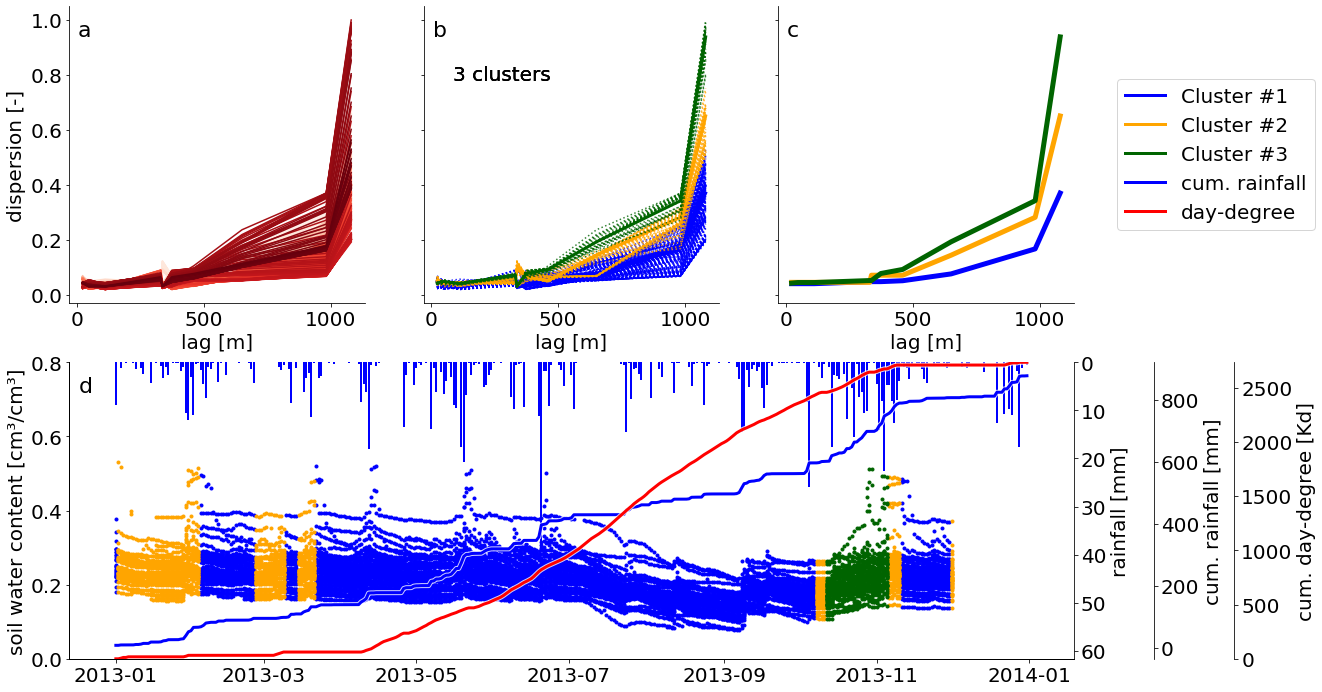

In [14]:
d = 1 # depth:= 30cm

# create figure
fig, axes = plt.subplots(2, 3, figsize=(3*6, 2*6), sharey='row')
largeax = plt.subplot2grid((2,3), (1,0), colspan=3)

# extract the compressed info
xbins = compress2013[d][0]
monos = compress2013[d][1]

# plot
plot_variogram(v2013[d], ax=axes[0,0], norm=True)
plot_cluster(v2013[d], mean_shifts2013[d], ax=axes[0,1], alpha=0.8, norm=True, ylabel=False)
plot_compressed(xbins, monos, ax=axes[0,2], ylabel=False)
clustered_series(m2013[d], mean_shifts2013[d], ax=largeax, rainfall=rr['20130101':'20131231'], temperature=temperature['20130101':'20131231'], 
                 cumsum=True, cl_threshold=cl_threshold, bbox=(1.25, 1.7))

for ax, l in zip(axes.flatten(), ('a', 'b', 'c')):
    ax.annotate(l, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=22)
largeax.annotate('d', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=22)

fig.savefig(main_name % ('30cm', 2013), bbox_inches='tight', dpi=70)

## 50 cm

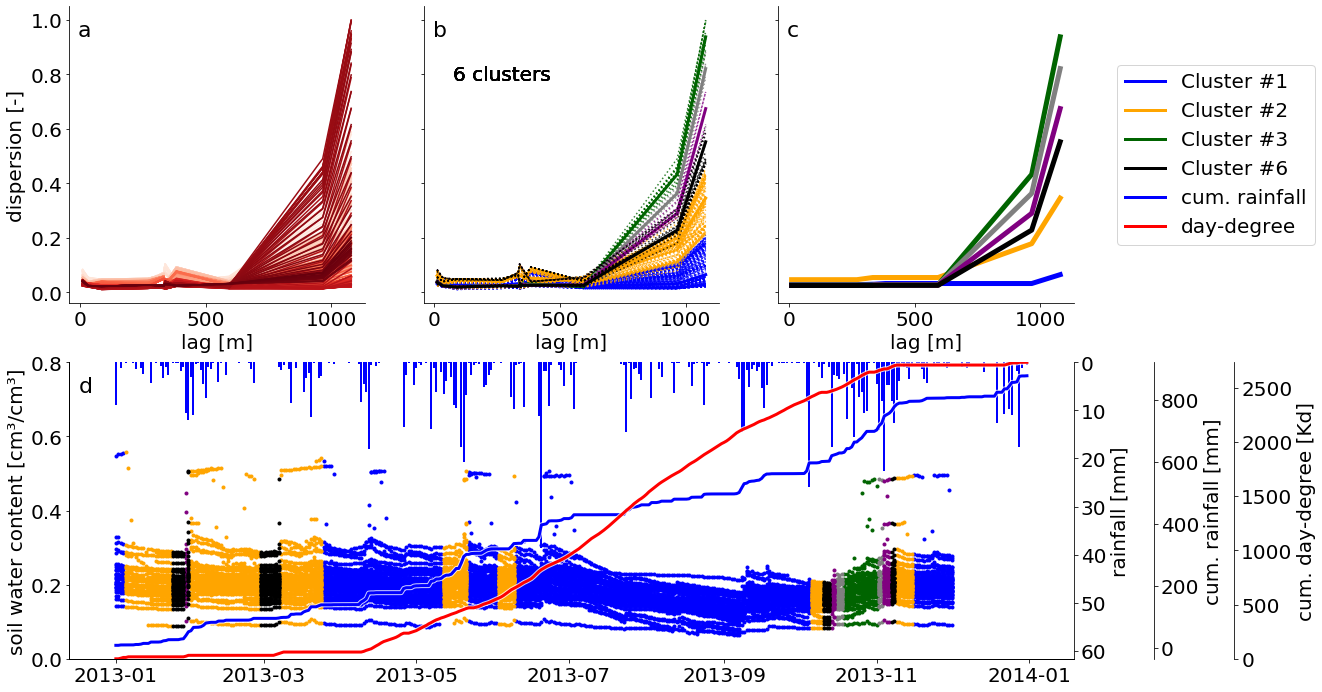

In [15]:
d = 2 # depth:= 50cm

# create figure
fig, axes = plt.subplots(2, 3, figsize=(3*6, 2*6), sharey='row')
largeax = plt.subplot2grid((2,3), (1,0), colspan=3)

# extract the compressed info
xbins = compress2013[d][0]
monos = compress2013[d][1]

# plot
plot_variogram(v2013[d], ax=axes[0,0], norm=True)
plot_cluster(v2013[d], mean_shifts2013[d], ax=axes[0,1], alpha=0.8, norm=True, ylabel=False)
plot_compressed(xbins, monos, ax=axes[0,2], ylabel=False)
clustered_series(m2013[d], mean_shifts2013[d], ax=largeax, rainfall=rr['20130101':'20131231'], temperature=temperature['20130101':'20131231'], 
                 cumsum=True, cl_threshold=cl_threshold, bbox=(1.25, 1.7))

for ax, l in zip(axes.flatten(), ('a', 'b', 'c')):
    ax.annotate(l, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=22)
largeax.annotate('d', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=22)

fig.savefig(main_name % ('50cm', 2013), bbox_inches='tight', dpi=70)

# 2014

Analysis

In [16]:
# get data
m2014 = list(extract((m10,m30,m50), '20140101', '20141231'))

# apply analysis
v2014 = variograms(m2014, (npos10, npos30, npos50), binify='uniform',window=window, estimator=estimator, rank=rank, maxlag=maxlag)
mean_shifts2014 = cluster_variograms(v2014, bandwidth=bandwidth)
compress2014 = [compress_cluster(ms, v) for ms, v in zip(mean_shifts2014, v2014)]

## 10 cm

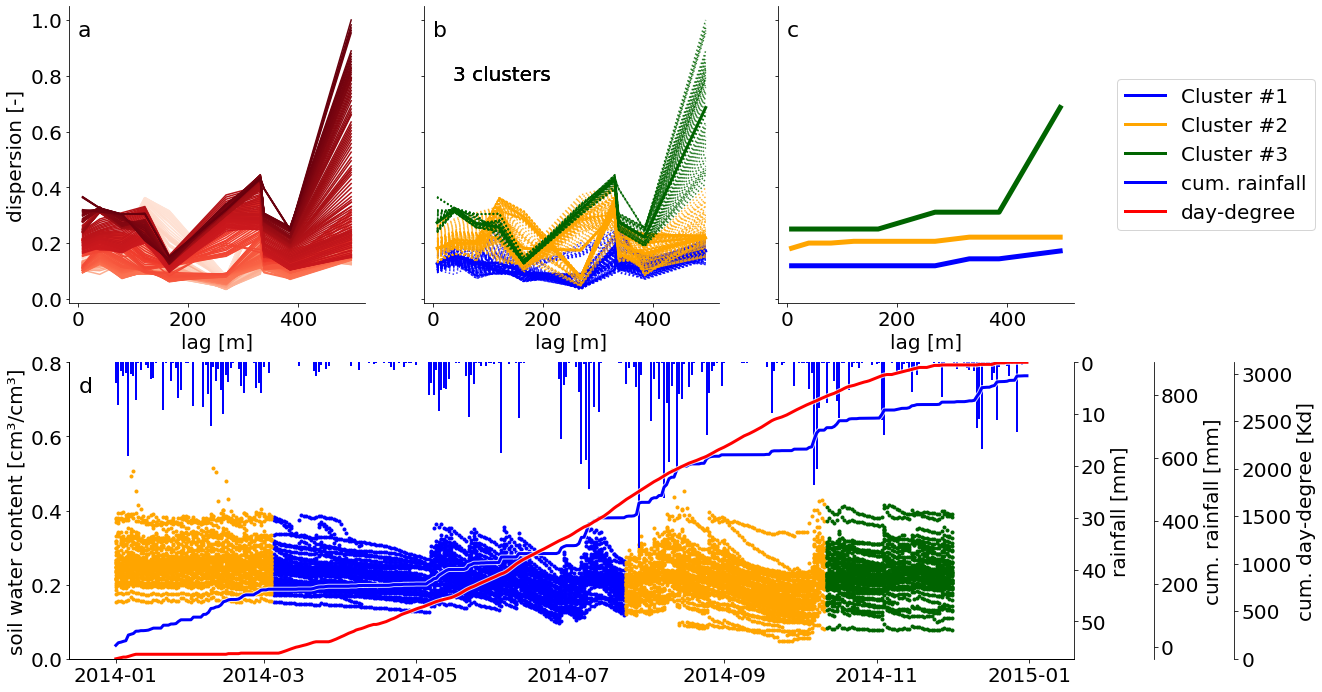

In [17]:
d = 0 # depth:= 10cm

# create figure
fig, axes = plt.subplots(2, 3, figsize=(3*6, 2*6), sharey='row')
largeax = plt.subplot2grid((2,3), (1,0), colspan=3)

# extract the compressed info
xbins = compress2014[d][0]
monos = compress2014[d][1]

# plot
plot_variogram(v2014[d], ax=axes[0,0], norm=True)
plot_cluster(v2014[d], mean_shifts2014[d], ax=axes[0,1], alpha=0.8, norm=True, ylabel=False)
plot_compressed(xbins, monos, ax=axes[0,2], ylabel=False)
clustered_series(m2014[d], mean_shifts2014[d], ax=largeax, rainfall=rr['20140101':'20141231'], temperature=temperature['20140101':'20141231'], 
                 cumsum=True, cl_threshold=cl_threshold, bbox=(1.25, 1.7))

for ax, l in zip(axes.flatten(), ('a', 'b', 'c')):
    ax.annotate(l, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=22)
largeax.annotate('d', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=22)

fig.savefig(main_name % ('10cm', 2014), bbox_inches='tight', dpi=70)

## 30 cm

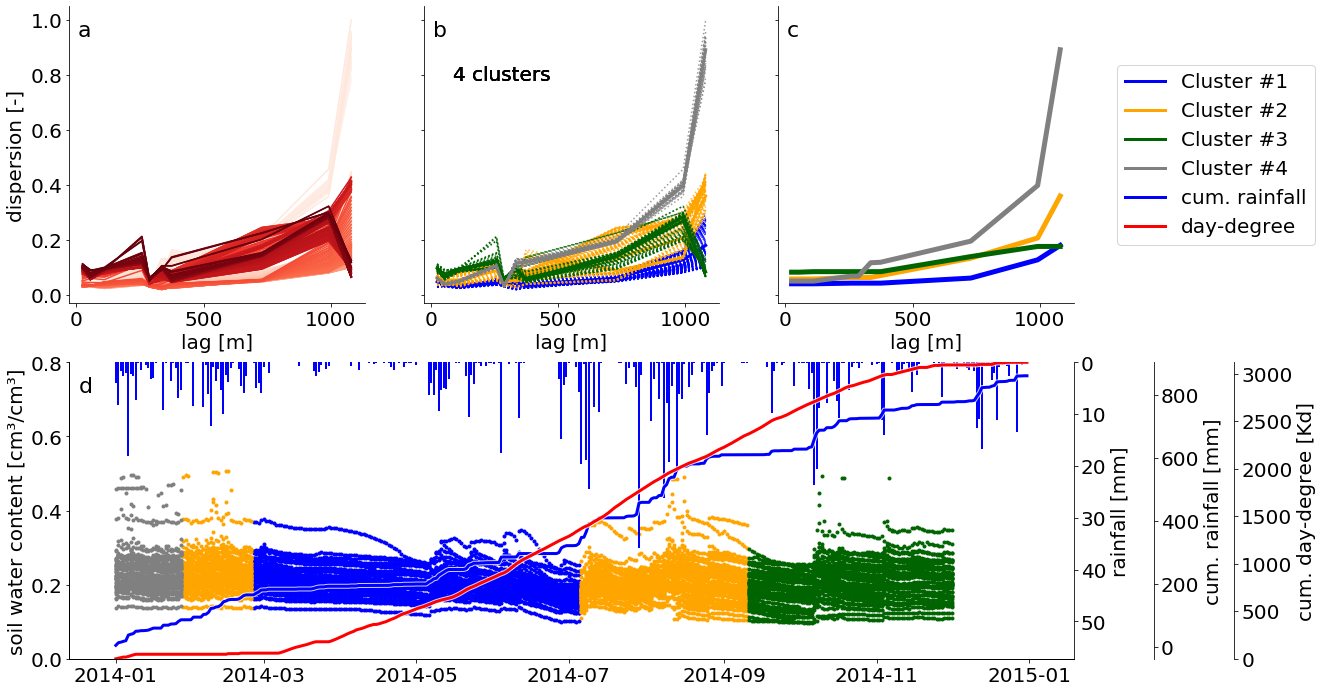

In [18]:
d = 1 # depth:= 30cm

# create figure
fig, axes = plt.subplots(2, 3, figsize=(3*6, 2*6), sharey='row')
largeax = plt.subplot2grid((2,3), (1,0), colspan=3)

# extract the compressed info
xbins = compress2014[d][0]
monos = compress2014[d][1]

# plot
plot_variogram(v2014[d], ax=axes[0,0], norm=True)
plot_cluster(v2014[d], mean_shifts2014[d], ax=axes[0,1], alpha=0.8, norm=True, ylabel=False)
plot_compressed(xbins, monos, ax=axes[0,2], ylabel=False)
clustered_series(m2014[d], mean_shifts2014[d], ax=largeax, rainfall=rr['20140101':'20141231'], temperature=temperature['20140101':'20141231'], 
                 cumsum=True, cl_threshold=cl_threshold, bbox=(1.25, 1.7))

for ax, l in zip(axes.flatten(), ('a', 'b', 'c')):
    ax.annotate(l, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=22)
largeax.annotate('d', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=22)

fig.savefig(main_name % ('30cm', 2014), bbox_inches='tight', dpi=70)

## 50 cm

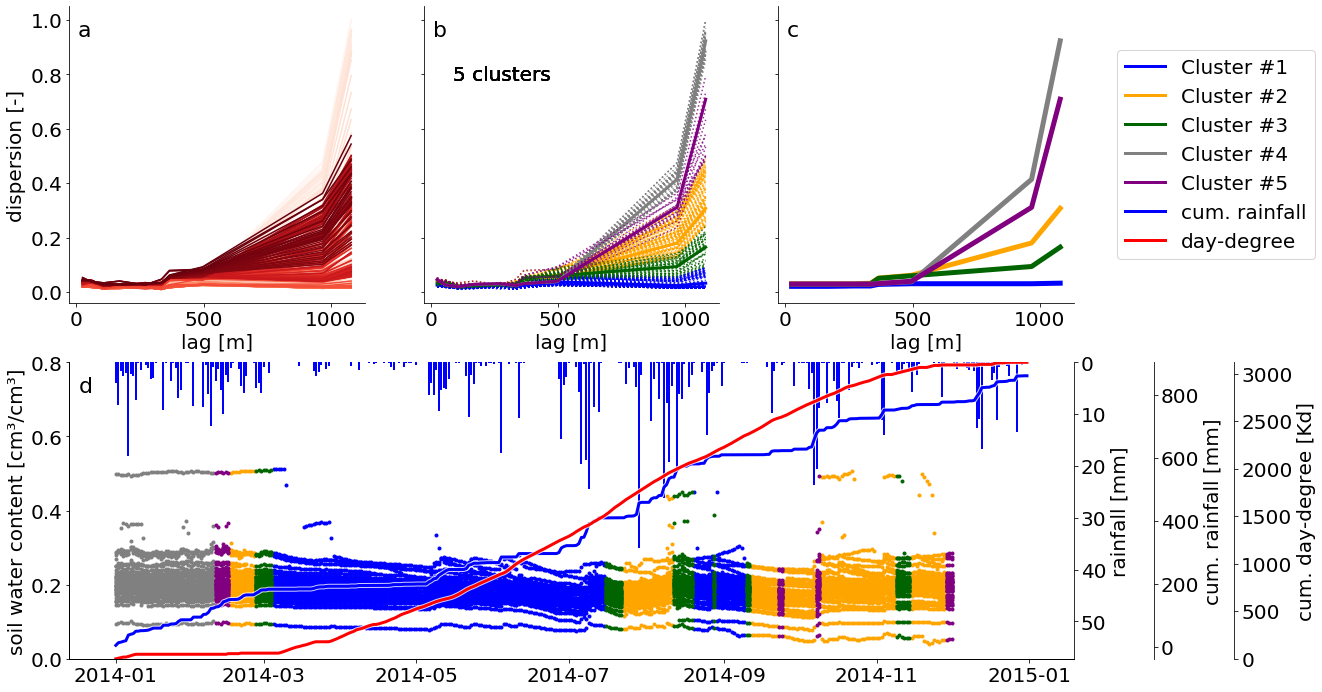

In [19]:
d = 2 # depth:= 50cm

# create figure
fig, axes = plt.subplots(2, 3, figsize=(3*6, 2*6), sharey='row')
largeax = plt.subplot2grid((2,3), (1,0), colspan=3)

# extract the compressed info
xbins = compress2014[d][0]
monos = compress2014[d][1]

# plot
plot_variogram(v2014[d], ax=axes[0,0], norm=True)
plot_cluster(v2014[d], mean_shifts2014[d], ax=axes[0,1], alpha=0.8, norm=True, ylabel=False)
plot_compressed(xbins, monos, ax=axes[0,2], ylabel=False)
clustered_series(m2014[d], mean_shifts2014[d], ax=largeax, rainfall=rr['20140101':'20141231'], temperature=temperature['20140101':'20141231'], 
                 cumsum=True, cl_threshold=cl_threshold, bbox=(1.25, 1.7))

for ax, l in zip(axes.flatten(), ('a', 'b', 'c')):
    ax.annotate(l, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=22)
largeax.annotate('d', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=22)

fig.savefig(main_name % ('50cm', 2014), bbox_inches='tight', dpi=70)

# 2015

Analysis

In [20]:
# get data
m2015 = list(extract((m10,m30,m50), '20150101', '20151231'))

# apply analysis
v2015 = variograms(m2015, (npos10, npos30, npos50), binify='uniform',window=window, estimator=estimator, rank=rank, maxlag=maxlag)
mean_shifts2015 = cluster_variograms(v2015, bandwidth=bandwidth)
compress2015 = [compress_cluster(ms, v) for ms, v in zip(mean_shifts2015, v2015)]

## 10 cm

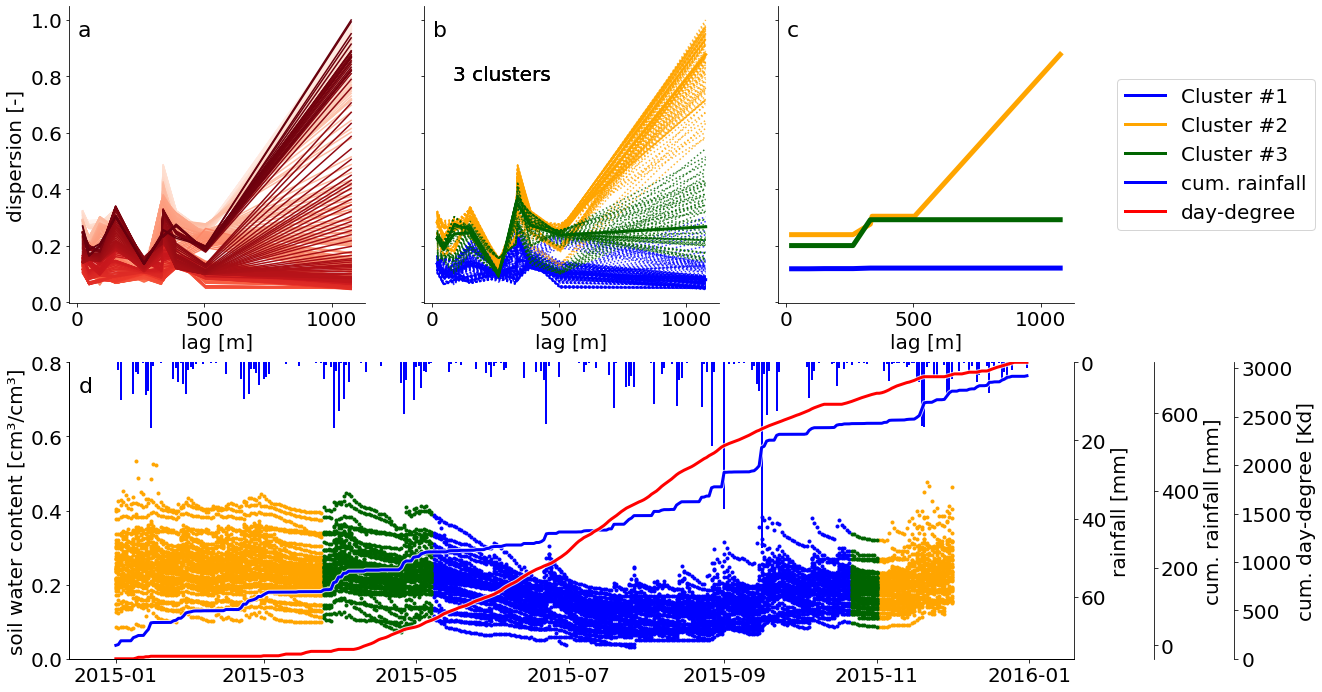

In [21]:
d = 0 # depth:= 10cm

# create figure
fig, axes = plt.subplots(2, 3, figsize=(3*6, 2*6), sharey='row')
largeax = plt.subplot2grid((2,3), (1,0), colspan=3)

# extract the compressed info
xbins = compress2015[d][0]
monos = compress2015[d][1]

# plot
plot_variogram(v2015[d], ax=axes[0,0], norm=True)
plot_cluster(v2015[d], mean_shifts2015[d], ax=axes[0,1], alpha=0.8, norm=True, ylabel=False)
plot_compressed(xbins, monos, ax=axes[0,2], ylabel=False)
clustered_series(m2015[d], mean_shifts2015[d], ax=largeax, rainfall=rr['20150101':'20151231'], temperature=temperature['20150101':'20151231'], 
                 cumsum=True, cl_threshold=cl_threshold, bbox=(1.25, 1.7))

for ax, l in zip(axes.flatten(), ('a', 'b', 'c')):
    ax.annotate(l, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=22)
largeax.annotate('d', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=22)

fig.savefig(main_name % ('10cm', 2015), bbox_inches='tight', dpi=70)

## 30 cm

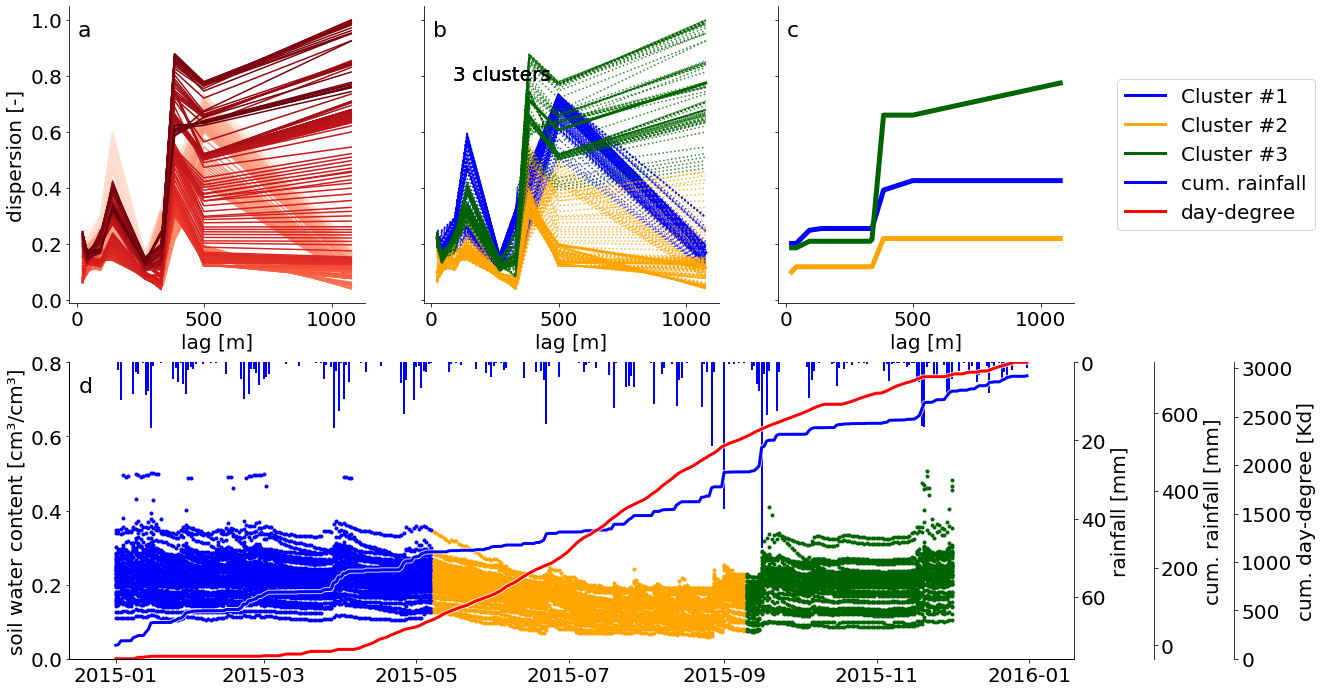

In [22]:
d = 1 # depth:= 30cm

# create figure
fig, axes = plt.subplots(2, 3, figsize=(3*6, 2*6), sharey='row')
largeax = plt.subplot2grid((2,3), (1,0), colspan=3)

# extract the compressed info
xbins = compress2015[d][0]
monos = compress2015[d][1]

# plot
plot_variogram(v2015[d], ax=axes[0,0], norm=True)
plot_cluster(v2015[d], mean_shifts2015[d], ax=axes[0,1], alpha=0.8, norm=True, ylabel=False)
plot_compressed(xbins, monos, ax=axes[0,2], ylabel=False)
clustered_series(m2015[d], mean_shifts2015[d], ax=largeax, rainfall=rr['20150101':'20151231'], temperature=temperature['20150101':'20151231'], 
                 cumsum=True, cl_threshold=cl_threshold, bbox=(1.25, 1.7))

for ax, l in zip(axes.flatten(), ('a', 'b', 'c')):
    ax.annotate(l, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=22)
largeax.annotate('d', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=22)

fig.savefig(main_name % ('30cm', 2015), bbox_inches='tight', dpi=70)

## 50 cm

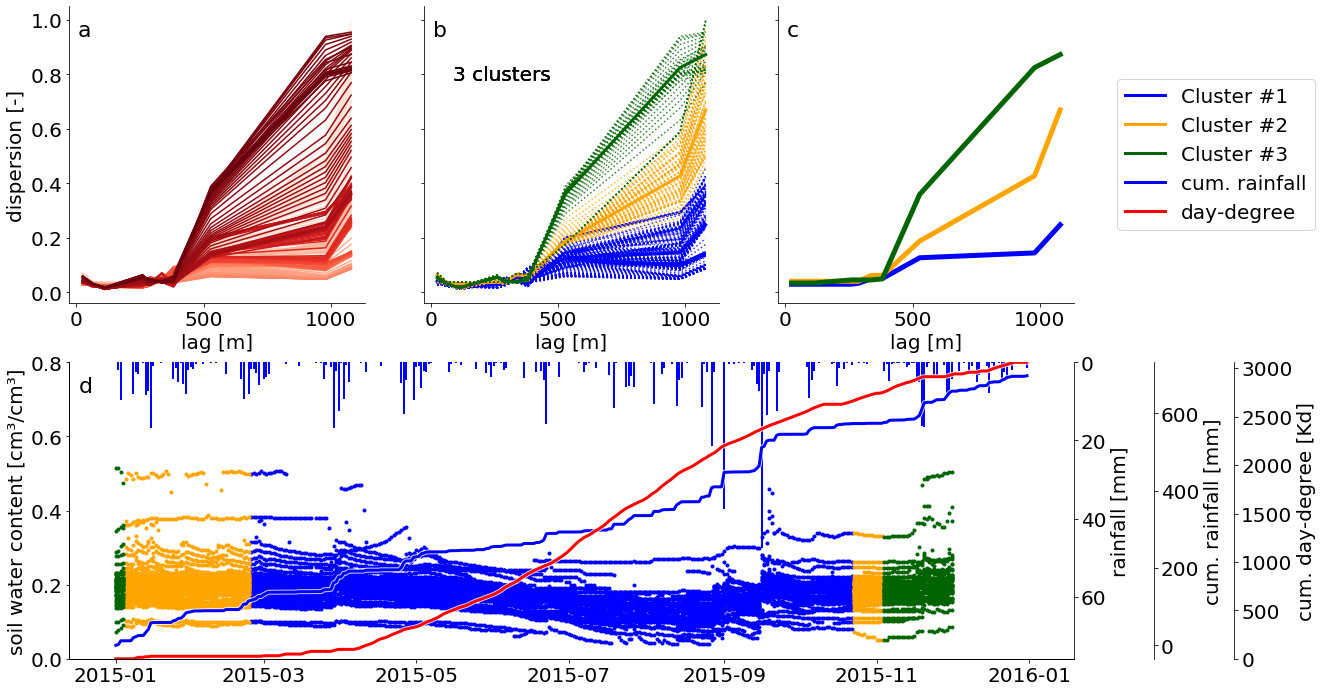

In [23]:
d = 2 # depth:= 50cm

# create figure
fig, axes = plt.subplots(2, 3, figsize=(3*6, 2*6), sharey='row')
largeax = plt.subplot2grid((2,3), (1,0), colspan=3)

# extract the compressed info
xbins = compress2015[d][0]
monos = compress2015[d][1]

# plot
plot_variogram(v2015[d], ax=axes[0,0], norm=True)
plot_cluster(v2015[d], mean_shifts2015[d], ax=axes[0,1], alpha=0.8, norm=True, ylabel=False)
plot_compressed(xbins, monos, ax=axes[0,2], ylabel=False)
clustered_series(m2015[d], mean_shifts2015[d], ax=largeax, rainfall=rr['20150101':'20151231'], temperature=temperature['20150101':'20151231'], 
                 cumsum=True, cl_threshold=cl_threshold, bbox=(1.25, 1.7))

for ax, l in zip(axes.flatten(), ('a', 'b', 'c')):
    ax.annotate(l, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=22)
largeax.annotate('d', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=22)

fig.savefig(main_name % ('50cm', 2015), bbox_inches='tight', dpi=70)

# 2016

Analysis

In [24]:
# get data
m2016 = list(extract((m10,m30,m50), '20160101', '20161231'))

# apply analysis
v2016 = variograms(m2016, (npos10, npos30, npos50), binify='uniform',window=window, estimator=estimator, rank=rank, maxlag=maxlag)
mean_shifts2016 = cluster_variograms(v2016, bandwidth=bandwidth)
compress2016 = [compress_cluster(ms, v) for ms, v in zip(mean_shifts2016, v2016)]

## 10 cm

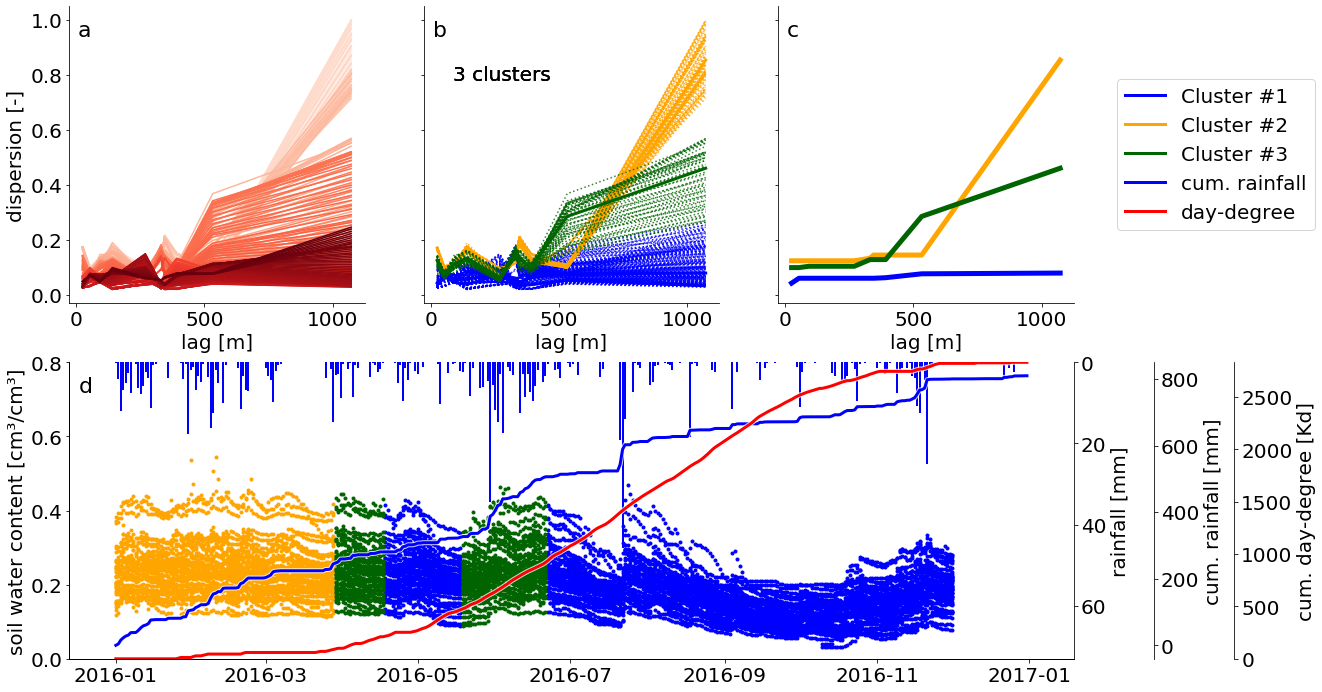

In [25]:
d = 0 # depth:= 10cm

# create figure
fig, axes = plt.subplots(2, 3, figsize=(3*6, 2*6), sharey='row')
largeax = plt.subplot2grid((2,3), (1,0), colspan=3)

# extract the compressed info
xbins = compress2016[d][0]
monos = compress2016[d][1]

# plot
plot_variogram(v2016[d], ax=axes[0,0], norm=True)
plot_cluster(v2016[d], mean_shifts2016[d], ax=axes[0,1], alpha=0.8, norm=True, ylabel=False)
plot_compressed(xbins, monos, ax=axes[0,2], ylabel=False)
clustered_series(m2016[d], mean_shifts2016[d], ax=largeax, rainfall=rr['20160101':'20161231'], temperature=temperature['20160101':'20161231'], 
                 cumsum=True, cl_threshold=cl_threshold, bbox=(1.25, 1.7))

for ax, l in zip(axes.flatten(), ('a', 'b', 'c')):
    ax.annotate(l, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=22)
largeax.annotate('d', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=22)

fig.savefig(main_name % ('10cm', 2016), bbox_inches='tight', dpi=70)

## 30 cm

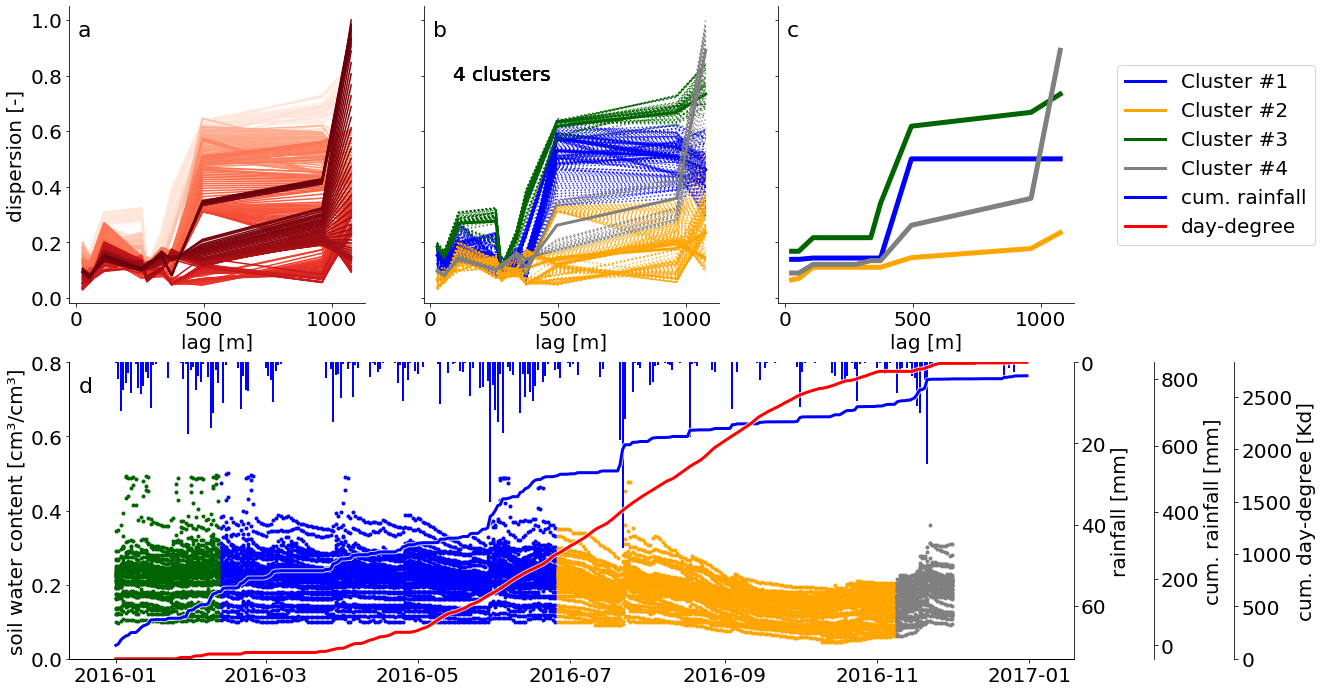

In [26]:
d = 1 # depth:= 30cm

# create figure
fig, axes = plt.subplots(2, 3, figsize=(3*6, 2*6), sharey='row')
largeax = plt.subplot2grid((2,3), (1,0), colspan=3)

# extract the compressed info
xbins = compress2016[d][0]
monos = compress2016[d][1]

# plot
plot_variogram(v2016[d], ax=axes[0,0], norm=True)
plot_cluster(v2016[d], mean_shifts2016[d], ax=axes[0,1], alpha=0.8, norm=True, ylabel=False)
plot_compressed(xbins, monos, ax=axes[0,2], ylabel=False)
clustered_series(m2016[d], mean_shifts2016[d], ax=largeax, rainfall=rr['20160101':'20161231'], temperature=temperature['20160101':'20161231'], 
                 cumsum=True, cl_threshold=cl_threshold, bbox=(1.25, 1.7))

for ax, l in zip(axes.flatten(), ('a', 'b', 'c')):
    ax.annotate(l, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=22)
largeax.annotate('d', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=22)

fig.savefig(main_name % ('30cm', 2016), bbox_inches='tight', dpi=70)

## 50 cm

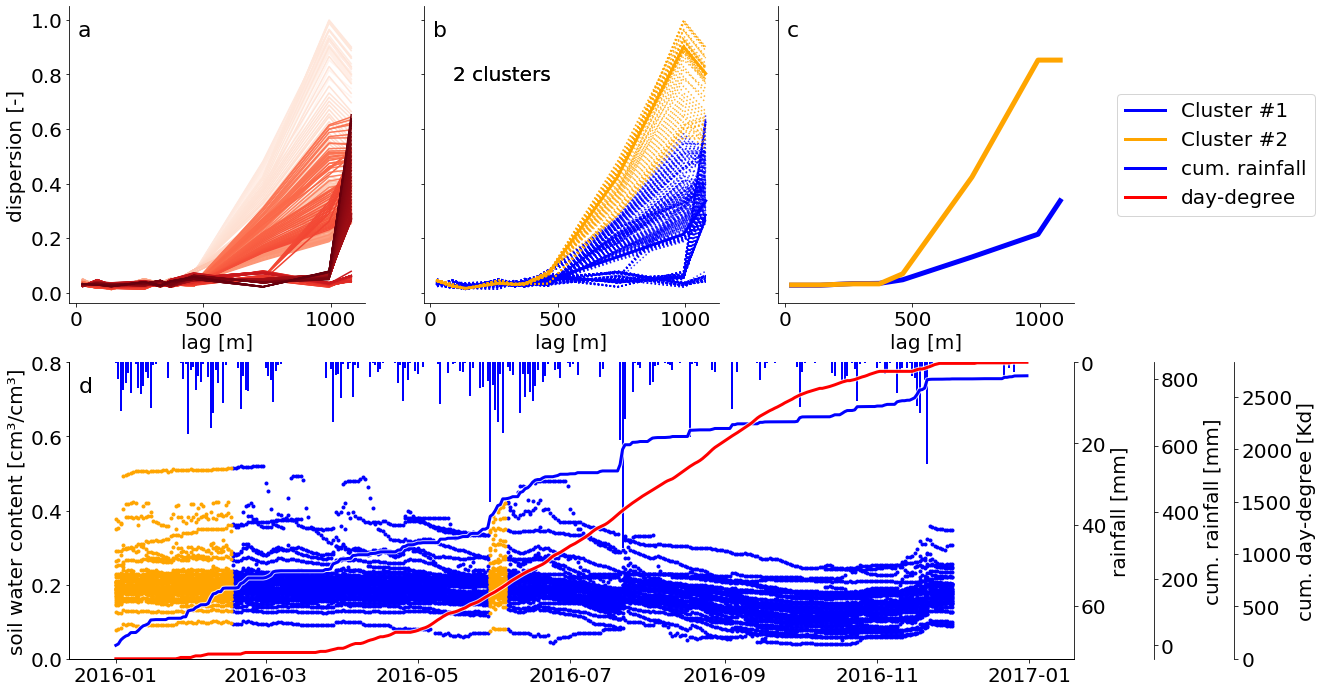

In [27]:
d = 2 # depth:= 50cm

# create figure
fig, axes = plt.subplots(2, 3, figsize=(3*6, 2*6), sharey='row')
largeax = plt.subplot2grid((2,3), (1,0), colspan=3)

# extract the compressed info
xbins = compress2016[d][0]
monos = compress2016[d][1]

# plot
plot_variogram(v2016[d], ax=axes[0,0], norm=True)
plot_cluster(v2016[d], mean_shifts2016[d], ax=axes[0,1], alpha=0.8, norm=True, ylabel=False)
plot_compressed(xbins, monos, ax=axes[0,2], ylabel=False)
clustered_series(m2016[d], mean_shifts2016[d], ax=largeax, rainfall=rr['20160101':'20161231'], temperature=temperature['20160101':'20161231'], 
                 cumsum=True, cl_threshold=cl_threshold, bbox=(1.25, 1.7))

for ax, l in zip(axes.flatten(), ('a', 'b', 'c')):
    ax.annotate(l, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=22)
largeax.annotate('d', xy=(0.01, 0.9), xycoords='axes fraction', fontsize=22)

fig.savefig(main_name % ('50cm', 2016), bbox_inches='tight', dpi=70)

# Combined Plots

## Depth

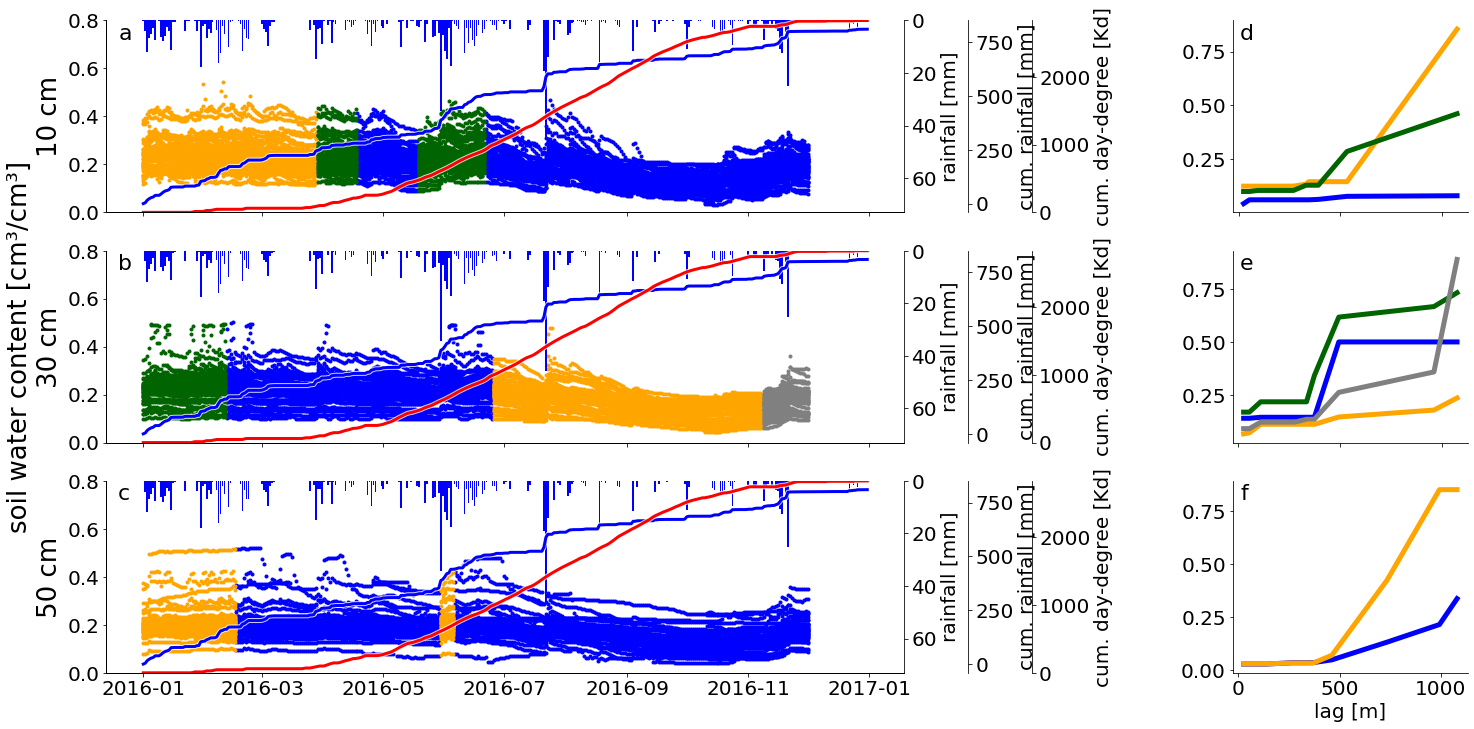

In [38]:
# create figure
#fig, _a = plt.subplots(3, 2, figsize=(3*6, 2*6), sharex=True)
#axes = _a.flatten()
fig = plt.figure(figsize=(4*6.1, 2*6))
axes = []
clus = []

axes.append(plt.subplot2grid((3, 5), (0, 0), colspan=3))
axes.append(plt.subplot2grid((3, 5), (1, 0), colspan=3))
axes.append(plt.subplot2grid((3, 5), (2, 0), colspan=3))
clus.append(plt.subplot2grid((3, 5), (0, 4), colspan=1))
clus.append(plt.subplot2grid((3, 5), (1, 4), colspan=1))
clus.append(plt.subplot2grid((3, 5), (2, 4), colspan=1))

# plot
for d, ax in zip((0, 1, 2, ), axes):
    clustered_series(m2016[d], mean_shifts2016[d], ax=ax, rainfall=rr['20160101':'20161231'], temperature=temperature['20160101':'20161231'], 
                 cumsum=True, cl_threshold=cl_threshold, legend=None)

for ax, l in zip(axes, ('a', 'b', 'c')):
    ax.annotate(l, xy=(0.015, 0.9), xycoords='axes fraction', fontsize=22)
    
for ax, l in zip(clus, ('d', 'e', 'f')):
    ax.annotate(l, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=22)

plot_compressed(compress2016[0][0], compress2016[0][1], ax=clus[0], ylabel=False, xlabel=False)
plot_compressed(compress2016[1][0], compress2016[1][1], ax=clus[1], ylabel=False, xlabel=False)
plot_compressed(compress2016[2][0], compress2016[2][1], ax=clus[2], ylabel=False)

axes[0].set_ylabel('10 cm', fontsize=26)
axes[0].set_xticklabels([])
clus[0].set_xticklabels([])
axes[1].set_ylabel('soil water content [cm³/cm³]\n30 cm', fontsize=26)
axes[1].set_xticklabels([])
clus[1].set_xticklabels([])
axes[2].set_ylabel('50 cm', fontsize=26)
fig.savefig(main_name % ('depth_compare', 2016), bbox_inches='tight', dpi=70)

## Inter-annual

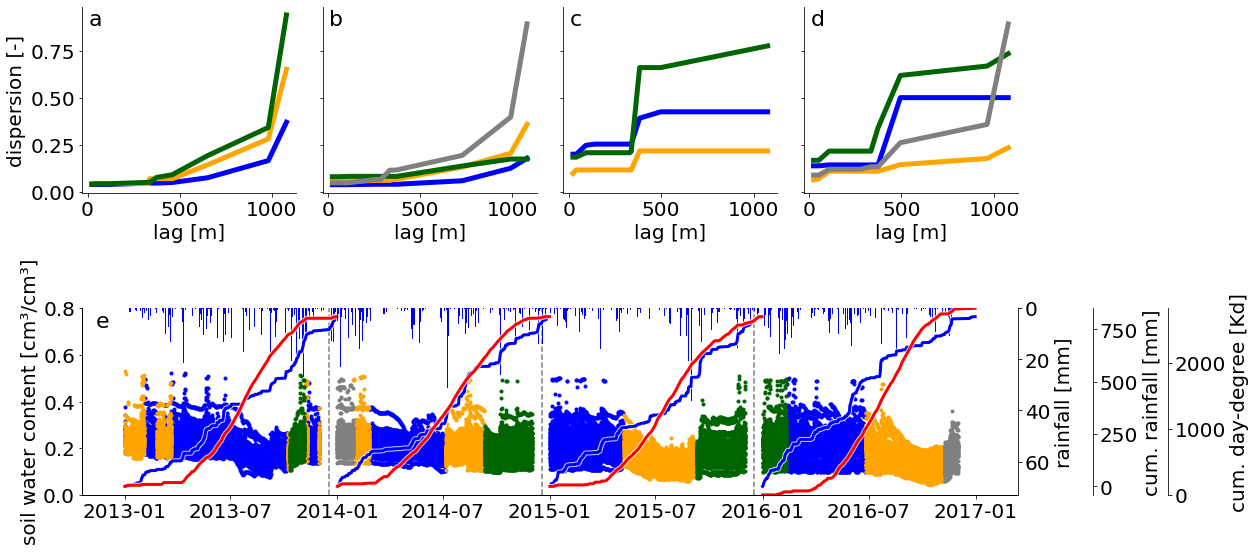

In [29]:
# prepare data - 30cm of all years
moistures = (m2013[1], m2014[1], m2015[1], m2016[1],)
clusters = (mean_shifts2013[1], mean_shifts2014[1], mean_shifts2015[1], mean_shifts2016[1])

# create figure
axes = []
fig = plt.figure(figsize=(18, 2*4))
axes.append(plt.subplot2grid((2,4), (0, 0), colspan=1))
axes.append(plt.subplot2grid((2,4), (0, 1), colspan=1, sharey=axes[0]))
axes.append(plt.subplot2grid((2,4), (0, 2), colspan=1, sharey=axes[0]))
axes.append(plt.subplot2grid((2,4), (0, 3), colspan=1, sharey=axes[0]))
ax = plt.subplot2grid((2, 4), (1, 0), colspan=4)
#fig, ax = plt.subplots(1, 1, figsize=(18, 1*4), sharex=True, sharey=True)


years = (2013, 2014, 2015, 2016)
# plot
for _moisture, _ms, y in zip(moistures, clusters, years):
    show = y == 2016
    clustered_series(_moisture, _ms, ax=ax, rainfall=rr['%d0101' % y:'%d1231' % y], temperature=temperature['%d0101' % y:'%d1231' % y], 
                 cumsum=True, cl_threshold=cl_threshold, legend=None, show_spines=show)

ax.vlines([dt(2013, 12, 18), dt(2014, 12, 18), dt(2015, 12, 18)], 0, 0.8, linestyle='--', color='grey')

# plot centroids
plot_compressed(compress2013[1][0], compress2013[1][1], ax=axes[0], ylabel=True, xlabel=True)
plot_compressed(compress2014[1][0], compress2014[1][1], ax=axes[1], ylabel=False, xlabel=True)
plot_compressed(compress2015[1][0], compress2015[1][1], ax=axes[2], ylabel=False, xlabel=True)
plot_compressed(compress2016[1][0], compress2016[1][1], ax=axes[3], ylabel=False, xlabel=True)

# hide labels
for a in axes[1:]:
    plt.setp(a.get_yticklabels(), visible=False)

# annotate
for a, l in zip(axes, ('a', 'b', 'c', 'd')):
    a.annotate(l, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=22)
ax.annotate('e', xy=(0.015, 0.9), xycoords='axes fraction', fontsize=22)
    
plt.tight_layout()
fig.savefig(main_name % ('interannual', 1316), bbox_inches='tight', dpi=70)

## Uncertainty propagation

### At one example

Only for 30cm depth in 2016:

(Ableitlung 1/2 * ( Summe i (xi -yî))^(-1/2) * summe i( (2*(xi-yi)*(delta xi) )^2+ (2*(xi-yi)*(delta yi))^2)^1/2


In [30]:
variograms = (v2013, v2014, v2015, v2016)
dz = 0.02

def cressie_err(x):
    N = len(x)
    return 0.5 * (0.457+(1/N)+(0.045 / N**2))**-1 * 2 * ((1 / N) * np.sum(np.sqrt(np.abs(x))))**3 * (1 / N) * np.sqrt(np.sum(np.abs(x)**1)) 

def d_err(u, v, du, dv):
    return (0.5 * (  np.sum(np.abs(u-v)**-0.5) * np.sum((2*(u-v)*du)**2 + (2*(u-v) * dv)**2) ) )**0.5

def vario_err(v, dz):
    return np.fromiter((cressie_err(c) * np.sqrt(2) * dz for c in v.lag_classes()), dtype=float)

def varios_err(variograms, dz):
    return np.asarray([vario_err(v, dz=dz) for v in variograms])

In [31]:
variogram_errors = list()

for v_year in variograms:
    variogram_errors.append([varios_err(v_depth, dz=dz) for v_depth in v_year])

In [32]:
# errors of one depth in one year
_v2016_10 = variograms[3][1]
_v2016_10_err = variogram_errors[3][1]


dm_v = pdist([_.experimental for _ in _v2016_10])
dm_err = np.ones(dm_v.shape) * -1

k = 0
for i in range(len(_v2016_10_err)):
    for j in range(len(_v2016_10_err)):
        if i > j:
            dm_err[k] = d_err(_v2016_10[i].experimental, _v2016_10[j].experimental, _v2016_10_err[i], _v2016_10_err[j])
            k += 1

In [33]:
print(np.mean(dm_v), np.min(dm_v), np.max(dm_v))
print(np.mean(_v2016_10_err), np.min(_v2016_10_err), np.max(_v2016_10_err))
print(np.mean(dm_err), np.min(dm_err), np.max(dm_err))

0.007256814650269572 2.0498315605701888e-05 0.017369805407659145
3.0382558527904338e-05 5.080227017303131e-06 0.00015026920248325287
1.7624505670933738e-05 7.146598451708756e-08 0.00026782699941538


### For all data

In [34]:
all_vs = list()
all_errs = list()

for v, err in zip(variograms, variogram_errors):
    all_vs.extend([_.experimental for _ in v[0]])
    all_vs.extend([_.experimental for _ in v[1]])
    all_vs.extend([_.experimental for _ in v[2]])
    all_errs.extend(err[0])
    all_errs.extend(err[1])
    all_errs.extend(err[2])
assert len(all_vs) == len(all_errs)

dm = pdist(all_vs)
dme = np.ones(dm.shape) * -1

k = 0
for i in range(len(all_errs)):
    for j in range(len(all_errs)):
        if i > j:
            dme[k] = d_err(all_vs[i], all_vs[j], all_errs[i], all_errs[j])
            k += 1


In [35]:
from skinfo import entropy
print('Maximum dispersion function distance: ', np.max(dm))
print('Maximum uncertainty of distance:      ', np.max(dme))
bins = np.arange(0, np.max(dm), np.max(dme))
#bins = np.arange(0, np.max(dm), np.percentile(dme, 95))
n = len(bins)
print('Information Entropy number of bins:   ', n)
print(bins)
print('Maximum Entropy of binning at uniform distribution: %.2f' % entropy(bins, bins))

Maximum dispersion function distance:  0.06902437182593772
Maximum uncertainty of distance:       0.005726514471981985
Information Entropy number of bins:    13
[0.         0.00572651 0.01145303 0.01717954 0.02290606 0.02863257
 0.03435909 0.0400856  0.04581212 0.05153863 0.05726514 0.06299166
 0.06871817]
Maximum Entropy of binning at uniform distribution: 3.55


## The information loss due to compression 

In [36]:
variograms = (v2013, v2014, v2015, v2016)
shifts = (mean_shifts2013, mean_shifts2014, mean_shifts2015, mean_shifts2016)

def extract_all_vectors(d, variograms):
    result = list()
    for variogram in variograms:
        result.extend([_.experimental for _ in variogram[d]])
    return result
    
import skinfo
from scipy.spatial.distance import pdist
def information_loss(variograms, mean_shift, bins=None, cl_threshold=10):
    _d = np.asarray([v.experimental for v in variograms])
    data = pdist(_d)
    if bins is None:
        bins = 15
    if isinstance(bins, int):
        bins = np.linspace(0, np.max(data), bins)
    intr = []
    for cl in np.unique(mean_shift.labels_):
        mem = data[np.where(mean_shift.labels_ == cl), ][0]
        if len(mem) > cl_threshold:
            intr.extend(len(mem) * [mean_shift.cluster_centers_[cl]])
    compressed = pdist(np.asarray(intr))
    
    return skinfo.kullback_leibler(compressed, data, bins), skinfo.entropy(data, bins)

all10cm = extract_all_vectors(1, variograms)


res = dict()
res['KL'] = dict()
res['N'] = dict()
res['H'] = dict()
res['H2'] = dict()
res['rel'] = dict()

for year, tup in zip((2013, 2014, 2015, 2016), zip(variograms, shifts)):
    v, ms = tup
    kld10, e10 = information_loss(v[0], ms[0], bins=bins)
    kld30, e30 = information_loss(v[1], ms[1], bins=bins)
    kld50, e50 = information_loss(v[2], ms[2], bins=bins)
    res['KL'][year] = {
        '10cm': kld10,
        '30cm': kld30,
        '50cm': kld50
    }
    res['N'][year] = {
        '10cm': len(np.unique(ms[0].labels_)),
        '30cm': len(np.unique(ms[1].labels_)),
        '50cm': len(np.unique(ms[2].labels_))
    }
    res['H'][year] = {
        '10cm': e10,
        '30cm': e30,
        '50cm': e50
    }
    res['H2'][year] = {
        '10cm': e10**2,
        '30cm': e30**2,
        '50cm': e50**2
    }
    res['rel'][year] = {
        '10cm': kld10 / (e10 + kld10),
        '30cm': kld30 / (e30 + kld30),
        '50cm': kld50 / (e50 + kld50)
    }
pprint(res)

{'H': {2013: {'10cm': 0.9661027934368046,
              '30cm': 1.4904779231660545,
              '50cm': 1.995448506253},
       2014: {'10cm': 1.352079889231375,
              '30cm': 1.5700497874754031,
              '50cm': 2.439567526212624},
       2015: {'10cm': 1.8749813753202447,
              '30cm': 1.1787810943484325,
              '50cm': 2.389513733502411},
       2016: {'10cm': 2.4903082942419292,
              '30cm': 1.4404685000048163,
              '50cm': 3.212315259499693}},
 'H2': {2013: {'10cm': 0.9333546074863972,
               '30cm': 2.2215244394453952,
               '50cm': 3.9818147411073292},
        2014: {'10cm': 1.8281200268639273,
               '30cm': 2.4650563351515586,
               '50cm': 5.951489714951181},
        2015: {'10cm': 3.515555157797796,
               '30cm': 1.3895248683932881,
               '50cm': 5.70977588259663},
        2016: {'10cm': 6.201635400370147,
               '30cm': 2.0749494995061255,
               '50cm': 10.31

In [37]:
for year in (2013, 2014, 2015, 2016):
    for d in ('10cm', '30cm', '50cm'):
        print(year, '&', d[:2] + ' \\unit{cm}', '&', 30, 
              res['N'][year][d], '&', 
              round(res['H'][year][d], 2), '&', 
              round(res['H2'][year][d], 2), '&',
              round(res['KL'][year][d], 2), '&', 
              round(res['rel'][year][d], 2), 
              '\\\\')

2013 & 10 \unit{cm} & 30 4 & 0.97 & 0.93 & 0.44 & 0.31 \\
2013 & 30 \unit{cm} & 30 3 & 1.49 & 2.22 & 0.06 & 0.04 \\
2013 & 50 \unit{cm} & 30 6 & 2.0 & 3.98 & 0.13 & 0.06 \\
2014 & 10 \unit{cm} & 30 3 & 1.35 & 1.83 & 0.22 & 0.14 \\
2014 & 30 \unit{cm} & 30 4 & 1.57 & 2.47 & 0.3 & 0.16 \\
2014 & 50 \unit{cm} & 30 5 & 2.44 & 5.95 & 0.28 & 0.1 \\
2015 & 10 \unit{cm} & 30 3 & 1.87 & 3.52 & 0.18 & 0.09 \\
2015 & 30 \unit{cm} & 30 3 & 1.18 & 1.39 & 0.09 & 0.07 \\
2015 & 50 \unit{cm} & 30 3 & 2.39 & 5.71 & 0.9 & 0.27 \\
2016 & 10 \unit{cm} & 30 3 & 2.49 & 6.2 & 0.76 & 0.23 \\
2016 & 30 \unit{cm} & 30 4 & 1.44 & 2.07 & 0.02 & 0.02 \\
2016 & 50 \unit{cm} & 30 2 & 3.21 & 10.32 & 2.5 & 0.44 \\
